# Data Wrangling and Preprocessing
This notebook loads the HR dataset, performs cleaning (imputation, encoding, scaling), removes sensitive columns for ethical reasons, and produces exploratory visualizations to support modeling and analysis.

In [206]:
# Core data libraries
import pandas as pd  # dataframes and csv I/O
import numpy as np  # numerical utilities

# Plotting libraries
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # statistical plotting built on matplotlib
import os  # path helpers

# Scikit-learn utilities used later for preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn for 
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


## Load & Merge Data
Brief: load CSV files from the `dataset` folder and merge tables side-by-side when they represent complementary information.

In [190]:
# Path to extracted dataset directory (relative to notebook)
extract_path = 'dataset'

# File names expected in the dataset folder. Update these if filenames differ.
csv_file_path1 = os.path.join(extract_path, 'general_data.csv')  # main table
csv_file_path2 = os.path.join(extract_path, 'manager_survey_data.csv')  # supplementary survey

# Load CSV files into pandas DataFrames. If files are large, consider using
# chunksize or dtypes to save memory.
general_data = pd.read_csv(csv_file_path1)
survey_data = pd.read_csv(csv_file_path2)

# Merge side-by-side (axis=1) because these datasets are complementary
data_merged = pd.concat([survey_data, general_data], axis=1)

# Quick peek at the combined dataframe
data_merged.head()

,EmployeeID,JobInvolvement,PerformanceRating,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1,3,3,51,No,Travel_Rarely,Sales,6,2,Life Sciences,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,2,2,4,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,3,3,3,32,No,Travel_Frequently,Research & Development,17,4,Other,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,4,2,3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,5,3,3,32,No,Travel_Rarely,Research & Development,10,1,Medical,...,4.0,Y,12,8,2,9.0,2,6,0,4


## Imputation (numeric features)
Use a median-based imputer to fill missing numeric values (robust to outliers).

In [191]:
# Imputation: use median to replace missing numeric values (robust to outliers)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Remove duplicate columns that sometimes appear after concatenation
data_merged = data_merged.loc[:, ~data_merged.columns.duplicated()]

# Select numeric-like columns (integers, floats, booleans treated as numeric)
numerical_columns = data_merged.select_dtypes(include=['float64', 'int64', 'boolean']).columns
data_merged_num = data_merged[numerical_columns].copy()

# Fit imputer and transform numeric data, returning a DataFrame with same column names
data_merged_num_imputed = pd.DataFrame(imputer.fit_transform(data_merged_num), columns=data_merged_num.columns)

# Sanity check: ensure imputation filled NaNs
data_merged_num_imputed.isnull().sum()

EmployeeID                 0
JobInvolvement             0
PerformanceRating          0
Age                        0
DistanceFromHome           0
Education                  0
EmployeeCount              0
JobLevel                   0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64

## Quick check: imputed numeric data
Inspect types and non-null counts after imputation to verify the operation.

In [192]:
# Quick info on the imputed numeric dataframe to inspect dtypes and non-null counts
data_merged_num_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   float64
 1   JobInvolvement           4410 non-null   float64
 2   PerformanceRating        4410 non-null   float64
 3   Age                      4410 non-null   float64
 4   DistanceFromHome         4410 non-null   float64
 5   Education                4410 non-null   float64
 6   EmployeeCount            4410 non-null   float64
 7   JobLevel                 4410 non-null   float64
 8   MonthlyIncome            4410 non-null   float64
 9   NumCompaniesWorked       4410 non-null   float64
 10  PercentSalaryHike        4410 non-null   float64
 11  StandardHours            4410 non-null   float64
 12  StockOptionLevel         4410 non-null   float64
 13  TotalWorkingYears        4410 non-null   float64
 14  TrainingTimesLastYear   

## Categorical Encoding (One-Hot)
One-hot encode text/category features. `handle_unknown='ignore'` avoids errors when applying the encoder to new data.

In [193]:
# Convert target variable 'Attrition' to numeric if present
if 'Attrition' in data_merged.columns:
    data_merged['Attrition'] = data_merged['Attrition'].map({'Yes': 1, 'No': 0})

# 1. Select categorical columns (object dtype). If there are category dtypes,
# consider using .select_dtypes(include=['object', 'category']) instead
data_merged_cat = data_merged.select_dtypes(include=[object])

# 2. Initialize OneHotEncoder. sparse_output=False returns a dense numpy array which
# we wrap into a DataFrame; change behavior for very high-cardinality features.
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 3. Fit and transform categorical columns into one-hot encoded array
data_merged_cat_encoded_array = cat_encoder.fit_transform(data_merged_cat)

# 4. Build feature names and DataFrame for the encoded categories
feature_names = cat_encoder.get_feature_names_out(data_merged_cat.columns)
data_merged_cat_encoded = pd.DataFrame(data_merged_cat_encoded_array, columns=feature_names, index=data_merged.index)

# Combine numeric imputed data and encoded categorical data into a single DataFrame
data_merged_raw = pd.concat([data_merged_num_imputed.reset_index(drop=True), data_merged_cat_encoded.reset_index(drop=True)], axis=1)

# Re-attach Attrition column (if present) to the prepared dataset
if 'Attrition' in data_merged.columns:
    data_merged_raw['Attrition'] = data_merged['Attrition'].values

# Quick check
data_merged_raw.head()

,EmployeeID,JobInvolvement,PerformanceRating,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,Attrition
0,1.0,3.0,3.0,51.0,6.0,2.0,1.0,1.0,131160.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,2.0,2.0,4.0,31.0,10.0,1.0,1.0,1.0,41890.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,3.0,3.0,3.0,32.0,17.0,4.0,1.0,4.0,193280.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,4.0,2.0,3.0,38.0,2.0,5.0,1.0,3.0,83210.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,5.0,3.0,3.0,32.0,10.0,1.0,1.0,1.0,23420.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


## Standardization (scaling numeric features)
Apply `StandardScaler` to numeric features to center and scale values (mean=0, std=1).

In [194]:
# Standardize numeric columns (zero mean, unit variance). This is helpful for
# many ML algorithms and for visualization comparability.
scaler = StandardScaler()
data_merged_num_scaled = pd.DataFrame(scaler.fit_transform(data_merged_num_imputed), columns=data_merged_num_imputed.columns, index=data_merged_num_imputed.index)

# If Attrition exists, attach it to the scaled numeric set for downstream analysis
if 'Attrition' in data_merged_raw.columns:
    data_merged_num_scaled['Attrition'] = data_merged_raw['Attrition'].values

# Verify result
data_merged_num_scaled.head()

,EmployeeID,JobInvolvement,PerformanceRating,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,-1.731658,0.379672,-0.426230,1.541369,-0.393938,-0.891688,0.0,-0.961486,1.405136,-0.678464,-1.150554,0.0,-0.932014,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,0
1,-1.730873,-1.026167,2.346151,-0.648668,0.099639,-1.868426,0.0,-0.961486,-0.491661,-1.079486,2.129306,0.0,0.241988,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,1
2,-1.730087,0.379672,-0.426230,-0.539166,0.963398,1.061787,0.0,1.749610,2.725053,-0.678464,-0.057267,0.0,2.589994,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,0
3,-1.729302,-1.026167,-0.426230,0.117845,-0.887515,2.038524,0.0,0.845911,0.386301,0.123580,-1.150554,0.0,2.589994,0.221606,1.707500,0.161947,1.493867,0.245834,0
4,-1.728516,0.379672,-0.426230,-0.539166,0.099639,-1.868426,0.0,-0.961486,-0.884109,0.524602,-0.877232,0.0,1.415991,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,0


## Prepare final dataset
Concatenate scaled numeric features and encoded categorical features to form the final `data_merged_prepared` dataset for analysis and modeling.

In [195]:
# Create a single prepared DataFrame combining scaled numeric and one-hot encoded
# categorical features. Ensure indexes align before concatenating.
data_merged_prepared = pd.concat([data_merged_num_scaled.reset_index(drop=True), data_merged_cat_encoded.reset_index(drop=True)], axis=1)

# Re-add Attrition to the final prepared dataset (if present)
if 'Attrition' in data_merged.columns:
    data_merged_prepared['Attrition'] = data_merged['Attrition'].values

# Quick sanity check of the prepared dataset
data_merged_prepared.head()

,EmployeeID,JobInvolvement,PerformanceRating,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,-1.731658,0.379672,-0.426230,1.541369,-0.393938,-0.891688,0.0,-0.961486,1.405136,-0.678464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-1.730873,-1.026167,2.346151,-0.648668,0.099639,-1.868426,0.0,-0.961486,-0.491661,-1.079486,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-1.730087,0.379672,-0.426230,-0.539166,0.963398,1.061787,0.0,1.749610,2.725053,-0.678464,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-1.729302,-1.026167,-0.426230,0.117845,-0.887515,2.038524,0.0,0.845911,0.386301,0.123580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-1.728516,0.379672,-0.426230,-0.539166,0.099639,-1.868426,0.0,-0.961486,-0.884109,0.524602,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


## Ethical / Privacy filtering
Drop identifiers and protected attributes to reduce privacy risk and potential bias in models.

In [196]:
# Define columns to remove for ethical/privacy reasons.
# - Red: identifiers or constants (remove always)
# - Orange: sensitive/protected attributes (drop to avoid potential bias)
unethical_columns = [
    'EmployeeID',            # Identifier (PII) -> remove
    'Over18_Y',              # Constant column (no predictive value)
    'Age',                   # Protected attribute (can lead to ageism)
    'EmployeeCount',          # Constant column (no predictive value)
    'StandardHours',        # Constant column (no predictive value)
    'Gender',                # Protected attribute (risk of sexism)
    'MaritalStatus_Married', # Sensitive/family status features
    'MaritalStatus_Single',  # Keep consistent with the encoded feature names if used
    'MaritalStatus_Divorced' # Included defensively if present
]

# Drop these columns from the prepared (raw) dataset and the scaled numeric set when present
df_ethical = data_merged_raw.drop(columns=unethical_columns, errors='ignore')
df_ethical_scaled = data_merged_num_scaled.drop(columns=unethical_columns, errors='ignore')

# Report the shape and remaining columns to verify the operation
print(f"Shape after removing unethical columns: {df_ethical.shape}")
print("Remaining columns:")
print(df_ethical.columns.tolist())

Shape after removing unethical columns: (4410, 38)
Remaining columns:
['JobInvolvement', 'PerformanceRating', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Repr

## Statistics & quick counts
Generate summary statistics and use histograms to inspect feature distributions after filtering.

In [197]:
# Summary statistics for the cleaned dataset (both raw and scaled numeric)
df_ethical.describe()
df_ethical_scaled.describe()

,JobInvolvement,PerformanceRating,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4410.000000
mean,6.646233e-17,-6.033974e-16,4.350262e-17,5.800349e-17,-2.698773e-17,5.598948e-17,-4.249561e-17,2.271803e-16,5.961470e-17,-8.740803e-17,1.095621e-16,-3.504377e-17,-4.028020e-19,-2.819614e-17,0.161224
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,0.367780
min,-2.432006e+00,-4.262300e-01,-1.010909e+00,-1.868426e+00,-9.614864e-01,-1.167343e+00,-1.079486e+00,-1.150554e+00,-9.320144e-01,-1.450719e+00,-2.171982e+00,-1.144294e+00,-6.791457e-01,-1.155935e+00,0.000000
25%,-1.026167e+00,-4.262300e-01,-8.875151e-01,-8.916883e-01,-9.614864e-01,-7.632087e-01,-6.784636e-01,-8.772324e-01,-9.320144e-01,-6.788770e-01,-6.201892e-01,-6.544537e-01,-6.791457e-01,-5.952272e-01,0.000000
50%,3.796721e-01,-4.262300e-01,-2.705440e-01,8.504925e-02,-5.778755e-02,-3.365516e-01,-2.774417e-01,-3.305891e-01,2.419883e-01,-1.643155e-01,1.557071e-01,-3.278933e-01,-3.687153e-01,-3.148735e-01,0.000000
75%,3.796721e-01,-4.262300e-01,5.932157e-01,1.061787e+00,8.459113e-01,3.988370e-01,5.246021e-01,7.626976e-01,2.419883e-01,4.788865e-01,1.557071e-01,3.252275e-01,2.521455e-01,8.065415e-01,0.000000
max,1.785511e+00,2.346151e+00,2.444129e+00,2.038524e+00,2.653309e+00,2.867626e+00,2.529712e+00,2.675949e+00,2.589994e+00,3.694896e+00,2.483396e+00,5.386914e+00,3.977310e+00,3.610079e+00,1.000000


## Distributions
Plot histograms to review the distribution of numeric features and identify skew or outliers.

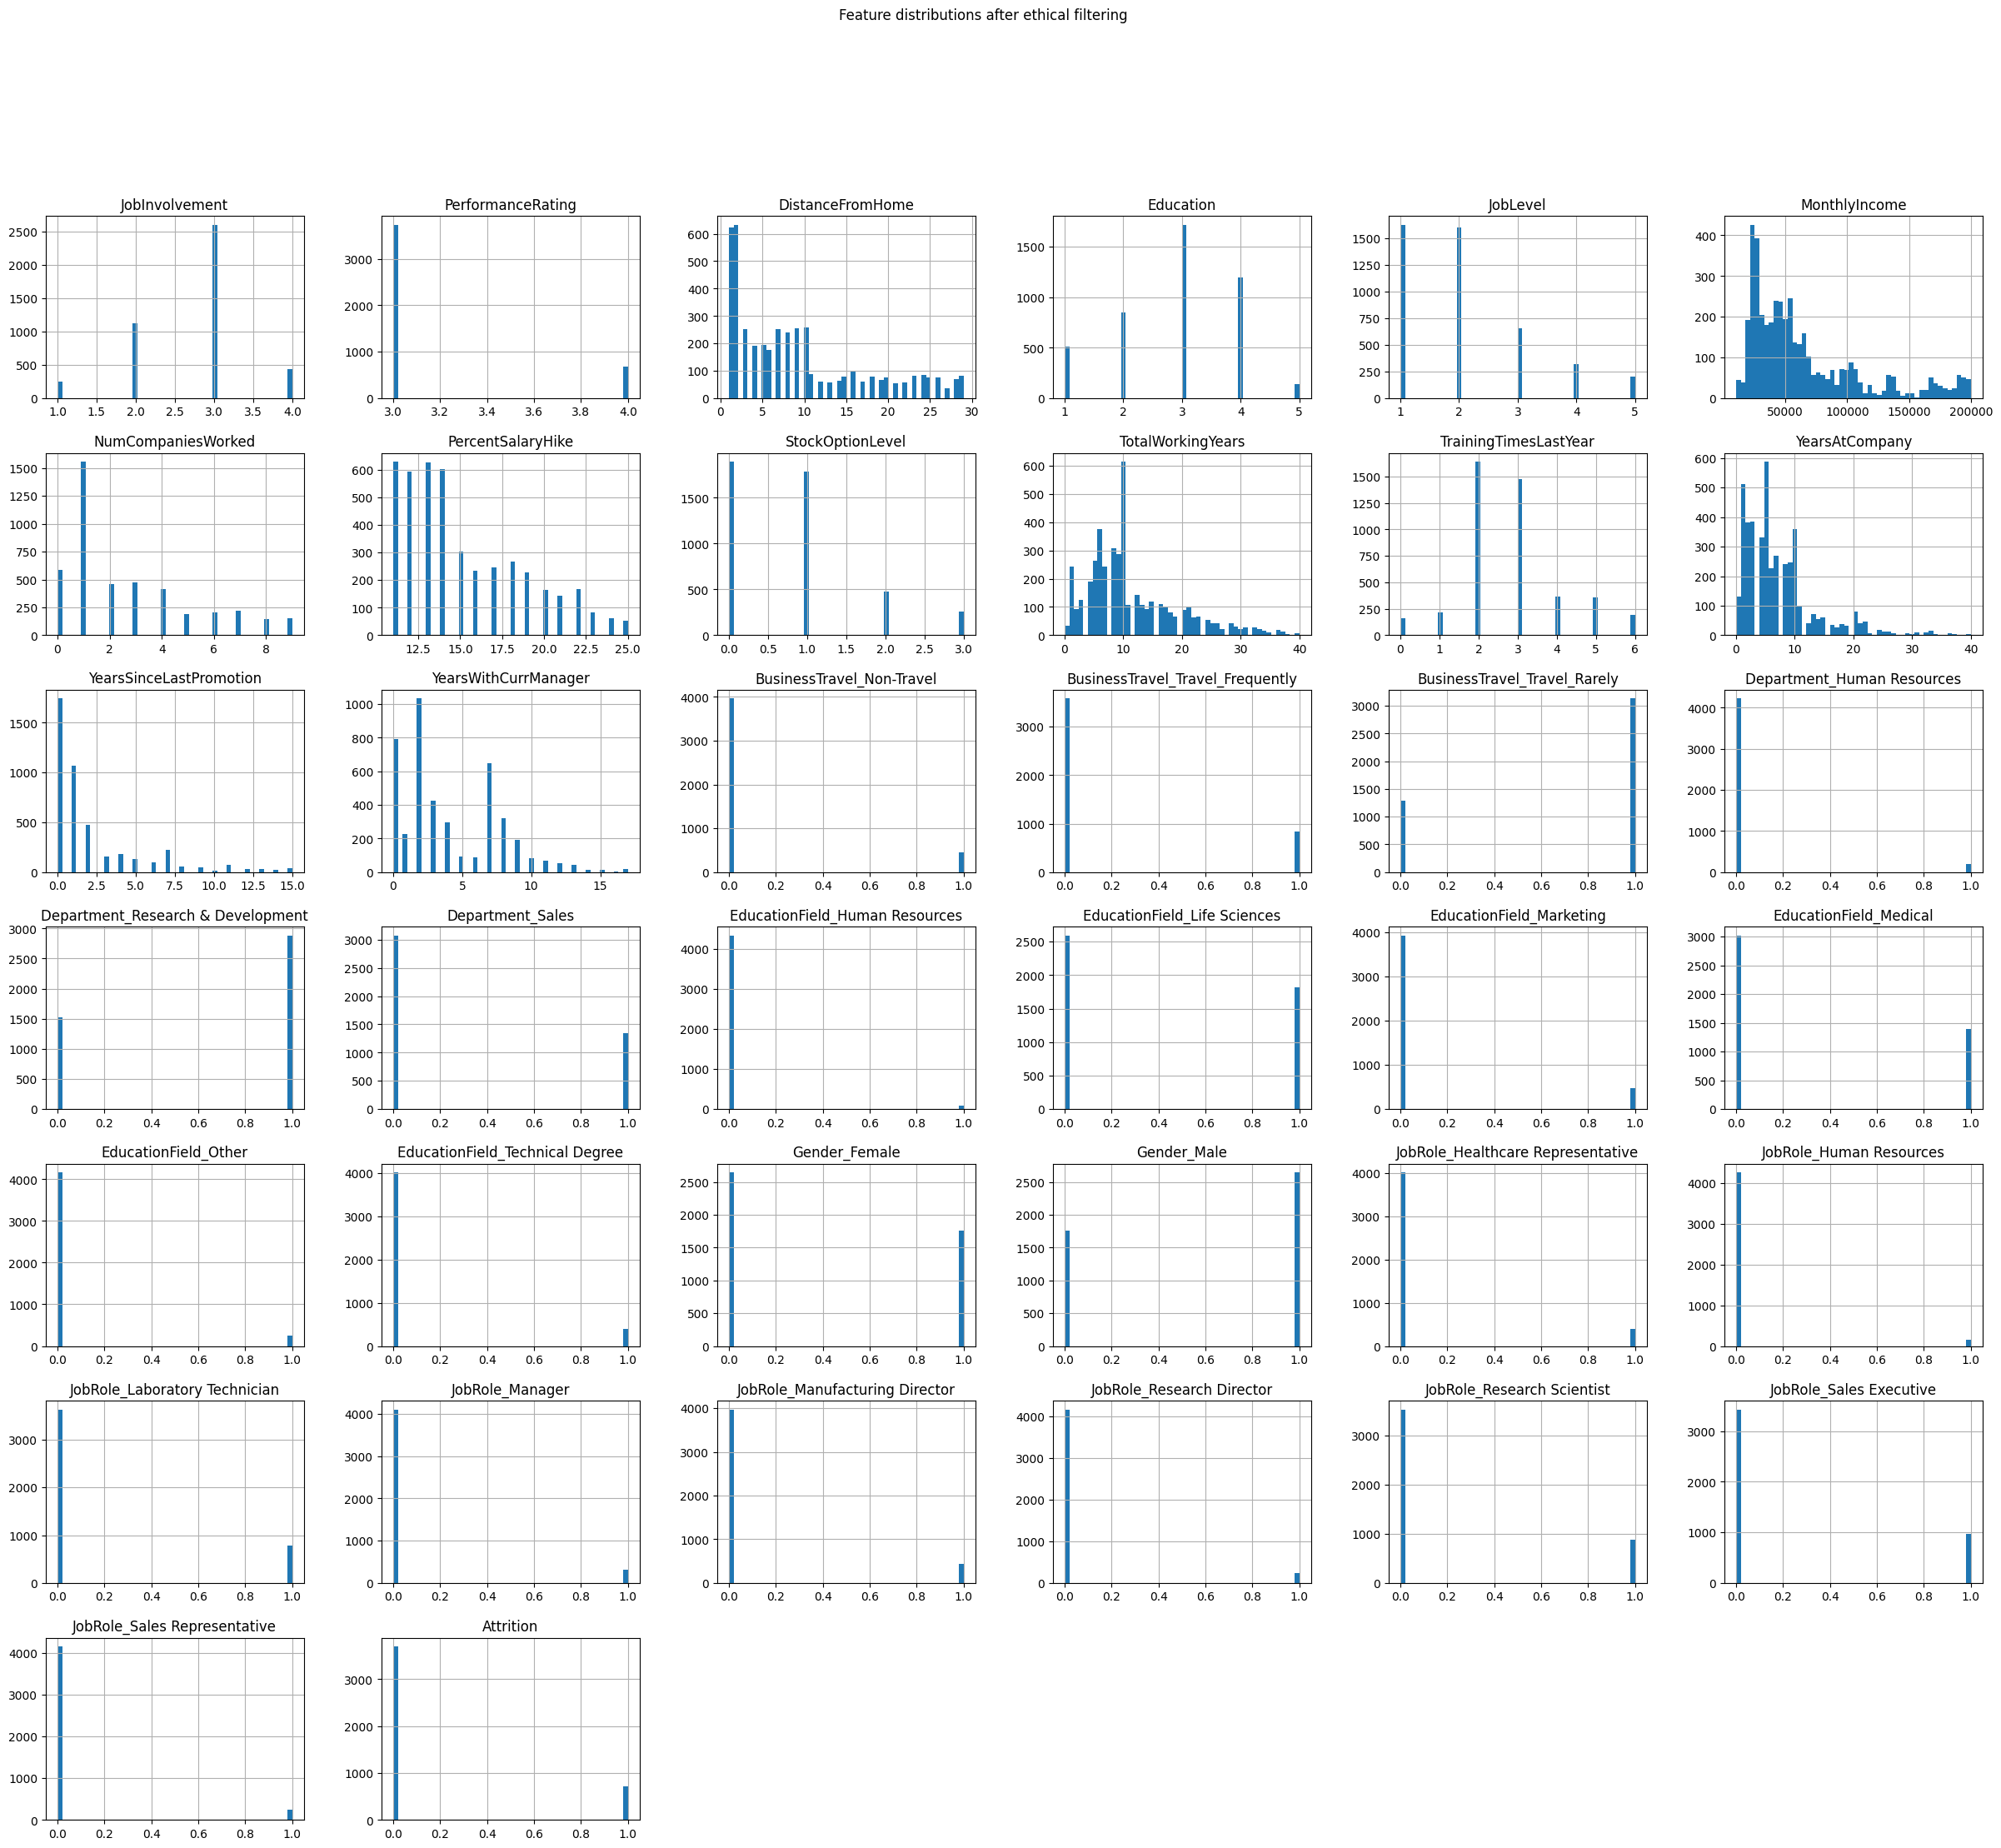

In [198]:
# Plot histograms for each numeric feature to inspect distributions
df_ethical.hist(bins=50, figsize=(30, 25))
plt.suptitle('Feature distributions after ethical filtering')
plt.show()

## Correlation matrix
Visualize pairwise correlations between scaled numeric features to detect multicollinearity.

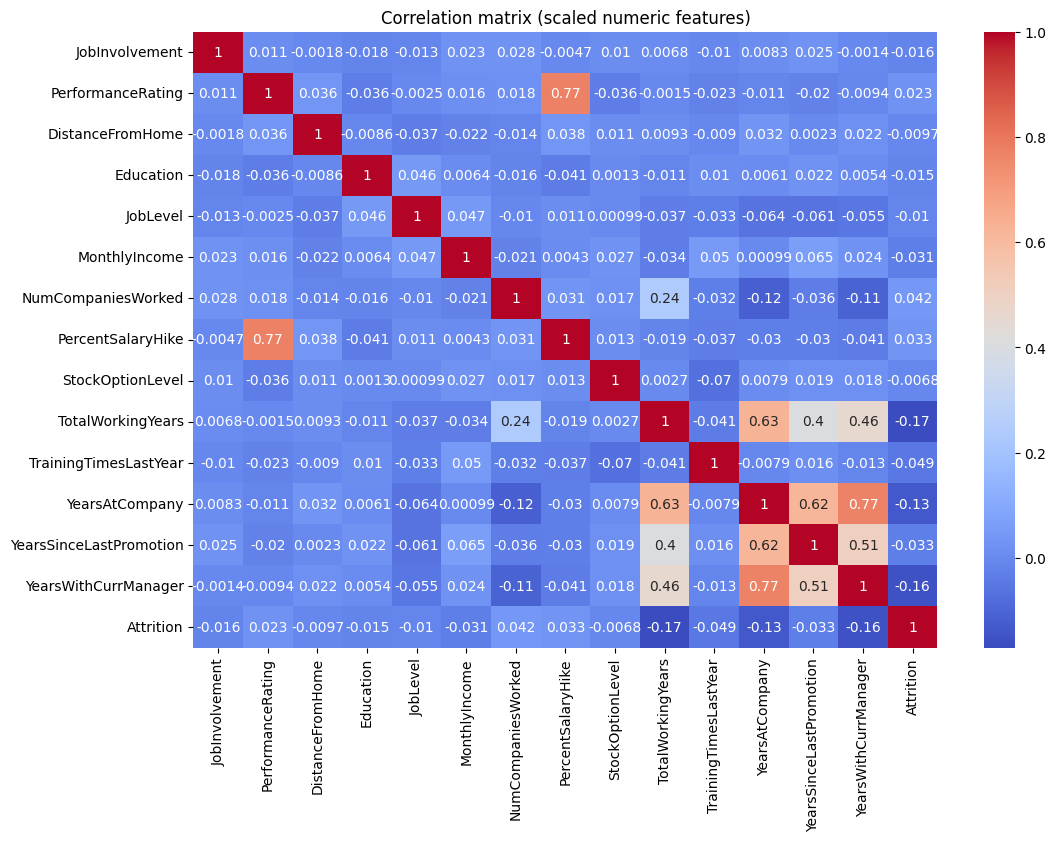

In [199]:
# Compute correlation matrix on scaled numeric features and visualize it
correlation = df_ethical_scaled.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation matrix (scaled numeric features)')
plt.show()

## Boxplots by Attrition
Show boxplots for selected numeric features grouped by `Attrition` to detect group differences that may be useful for modeling.

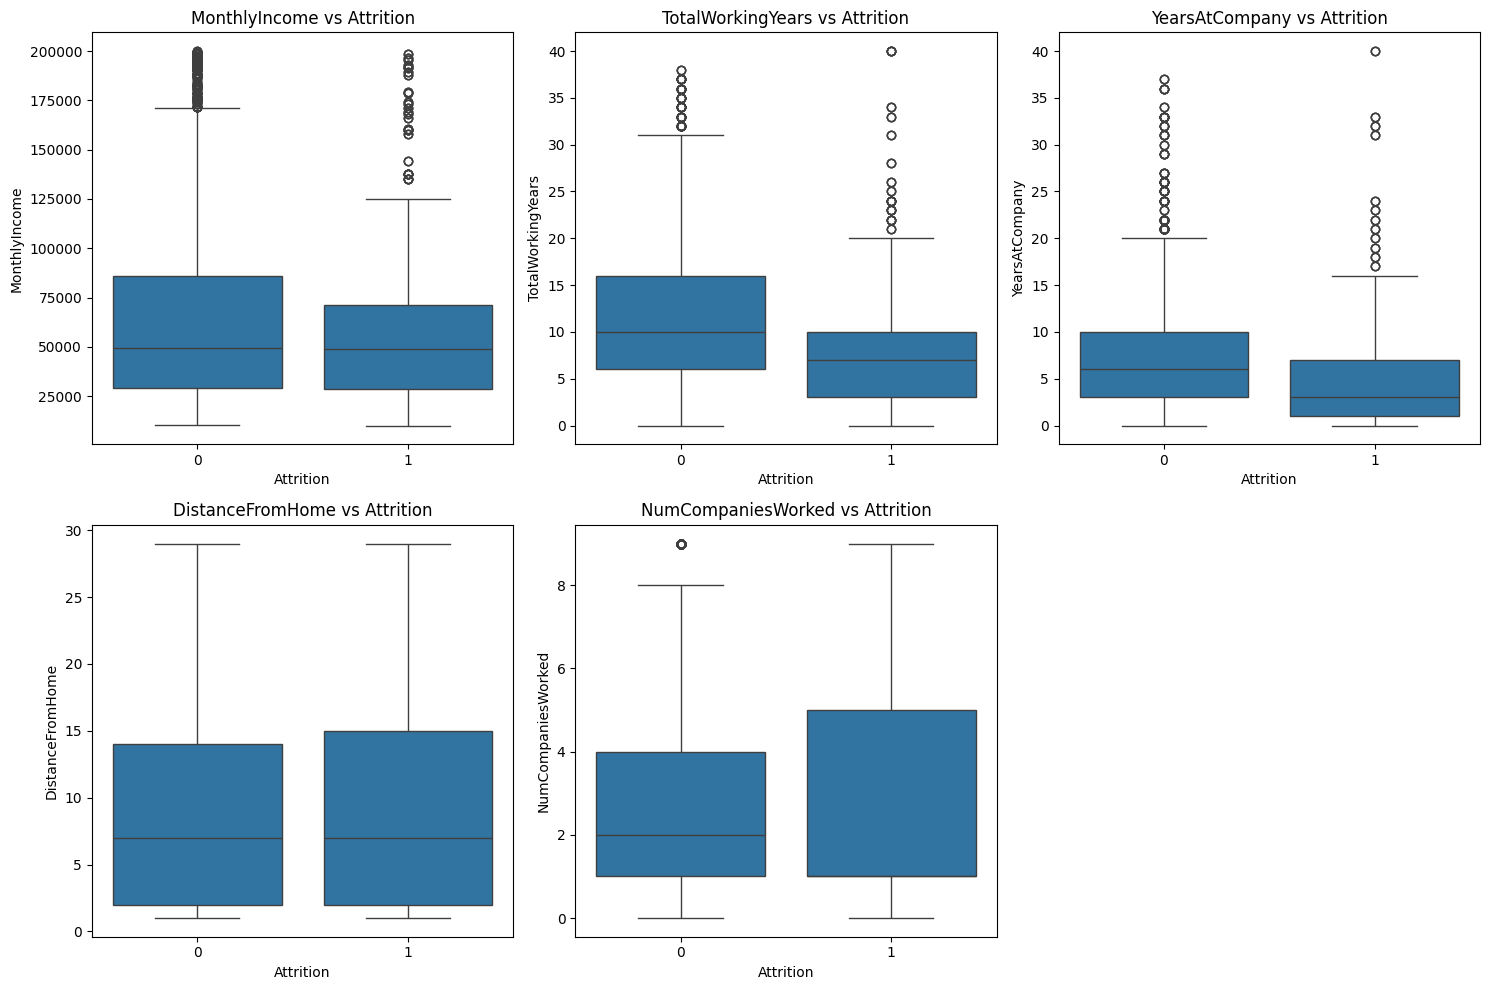

In [200]:
# Create boxplots for select numeric features split by Attrition to visually
# inspect whether the distribution differs between groups
cols_to_check = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome', 'NumCompaniesWorked']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_check):
    if col in df_ethical.columns:
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='Attrition', y=col, data=df_ethical)
        plt.title(f'{col} vs Attrition')

plt.tight_layout()
plt.show()

### Visualizing relationships between variables

We're going to create a few scatter plots to visualize the relationships between certain key variables.

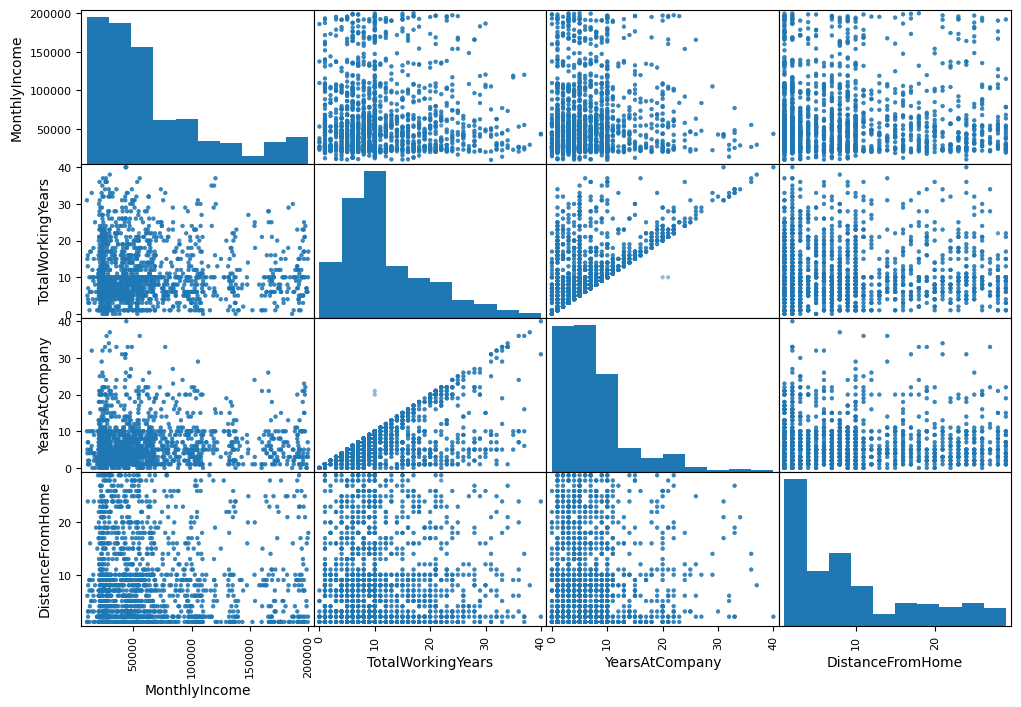

In [201]:
attributes = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome']
scatter_matrix = pd.plotting.scatter_matrix(df_ethical[attributes], figsize=(12, 8))
plt.show()


### Analyze attrition counts by department using one-hot encoded department columns

               Department  Attrition_Count
0         Human Resources               57
1  Research & Development              453
2                   Sales              201


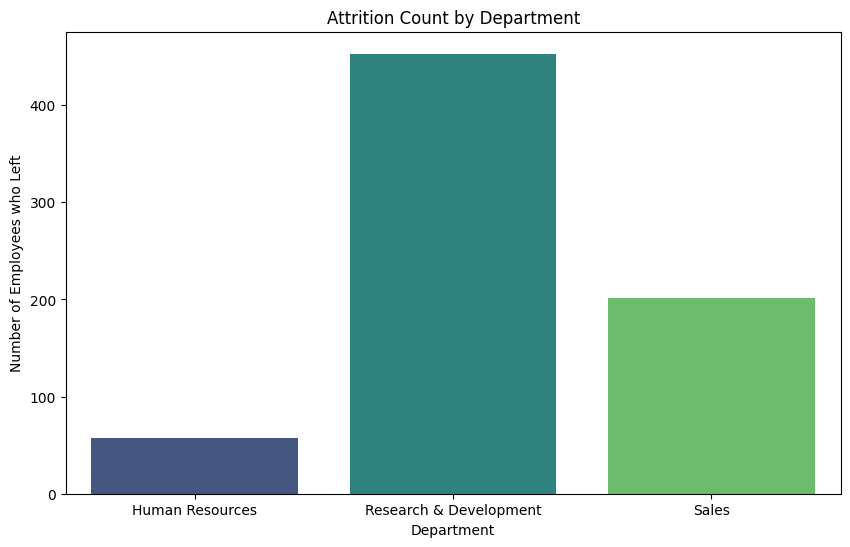

In [202]:

# 1. List of your department columns
dept_cols = ['Department_Human Resources', 'Department_Research & Development', 'Department_Sales']

# 2. Calculate the number of leavers (Attrition == 1) for each department
results = []
for col in dept_cols:
    # We count rows where the department is active (1) AND the employee left (1)
    # Ensure 'Attrition' is encoded as 0 and 1.
    count = df_ethical[(df_ethical[col] == 1) & (df_ethical['Attrition'] == 1)].shape[0]
    
    # Clean the name for the chart (e.g., remove "Department_")
    dept_name = col.replace('Department_', '')
    results.append({'Department': dept_name, 'Attrition_Count': count})

# 3. Create a small DataFrame for the results
df_res = pd.DataFrame(results)

# 4. Print the numbers
print(df_res)

# 5. Visualization (Barplot instead of Boxplot)
plt.figure(figsize=(10, 6))
sns.barplot(x='Department', y='Attrition_Count', data=df_res, palette='viridis',hue='Department')
plt.title("Attrition Count by Department")
plt.ylabel("Number of Employees who Left")
plt.xlabel("Department")
plt.show()

### Analyse target variable

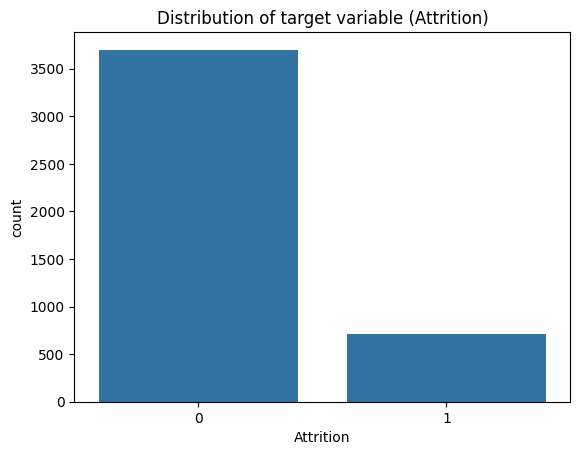

In [203]:
sns.countplot(x='Attrition', data=df_ethical)
plt.title('Distribution of target variable (Attrition)')
plt.show()

# MODELING AND TRAINING / TESTING :

In [204]:

# 1. Split X and y
X = df_ethical_scaled.drop('Attrition', axis=1) 
y = df_ethical_scaled['Attrition']

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       741
           1       0.22      0.65      0.33       141

    accuracy                           0.58       882
   macro avg       0.56      0.61      0.51       882
weighted avg       0.79      0.58      0.64       882

Matrice de Confusion (Régression Logistique) :
 [[423 318]
 [ 50  91]]


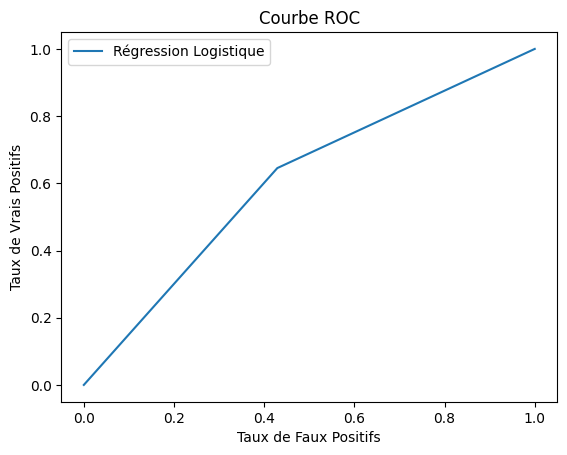

In [205]:

# 3. Model with class_weight='balanced'
# This is where the magic happens: the model penalizes errors on "1" more heavily
rf_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000)
rf_model.fit(X_train, y_train)

# 4. Evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de Confusion (Régression Logistique) :\n", conf_matrix)


# ROC curve
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred)
plt.plot(fpr_log_reg, tpr_log_reg, label="Régression Logistique")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


In [209]:

models = {
    "Perceptron": Perceptron(),
    "LogisticRegression": LogisticRegression(class_weight= 'balanced',max_iter=1000, random_state=42),
    "SVM": SVC(class_weight='balanced',probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Training and prediction
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)


In [210]:
from sklearn.metrics import confusion_matrix, classification_report

# Function for displaying results
def display_metrics(y_test):
    
    # Metric calculation
    for name, y_pred in predictions.items():
        # Confusion matrix
        print(f'Modele :{name}')
        conf_matrix_rf = confusion_matrix(y_test, y_pred)
        print(f"Matrice de Confusion :\n", conf_matrix_rf)

        # Classification report
        class_report_rf = classification_report(y_test, y_pred)
        print(f"Rapport de Classification :\n", class_report_rf)


display_metrics(y_test)

Modele :Perceptron
Matrice de Confusion :
 [[635 106]
 [106  35]]
Rapport de Classification :
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       741
           1       0.25      0.25      0.25       141

    accuracy                           0.76       882
   macro avg       0.55      0.55      0.55       882
weighted avg       0.76      0.76      0.76       882

Modele :LogisticRegression
Matrice de Confusion :
 [[423 318]
 [ 50  91]]
Rapport de Classification :
               precision    recall  f1-score   support

           0       0.89      0.57      0.70       741
           1       0.22      0.65      0.33       141

    accuracy                           0.58       882
   macro avg       0.56      0.61      0.51       882
weighted avg       0.79      0.58      0.64       882

Modele :SVM
Matrice de Confusion :
 [[557 184]
 [ 24 117]]
Rapport de Classification :
               precision    recall  f1-score   support

     

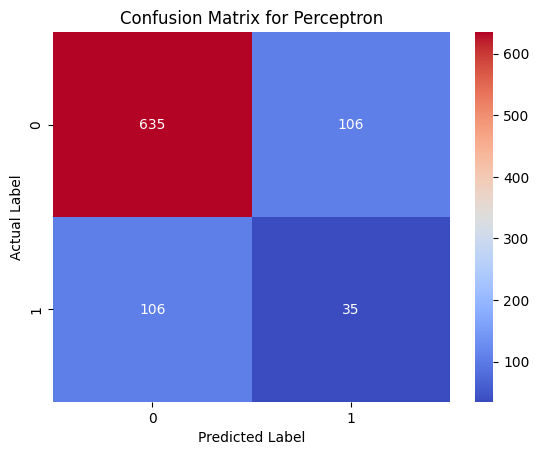

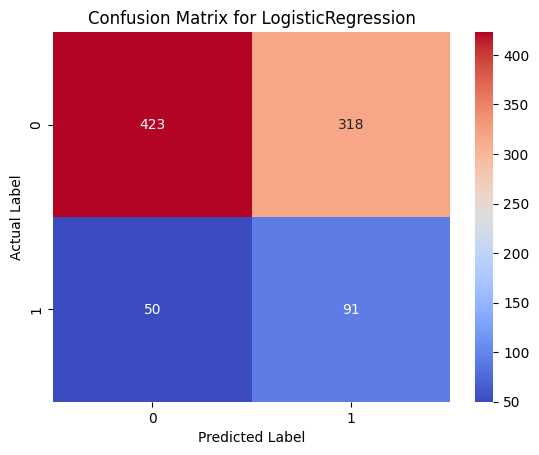

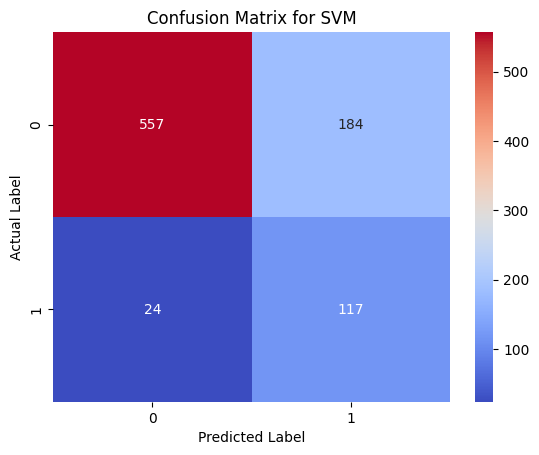

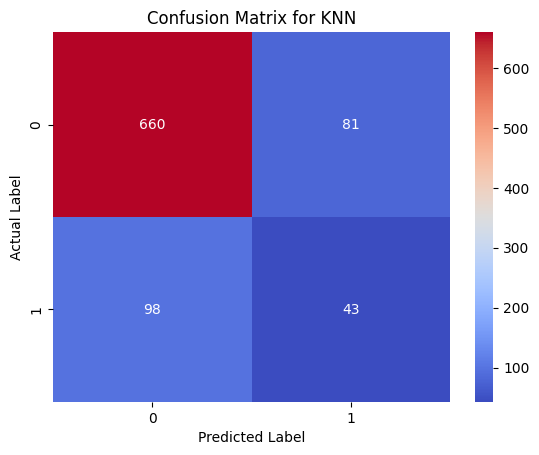

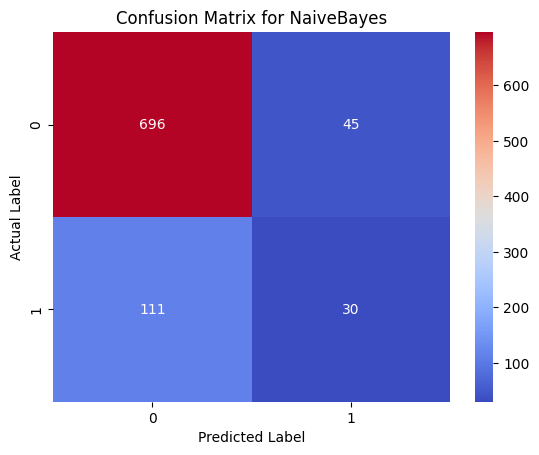

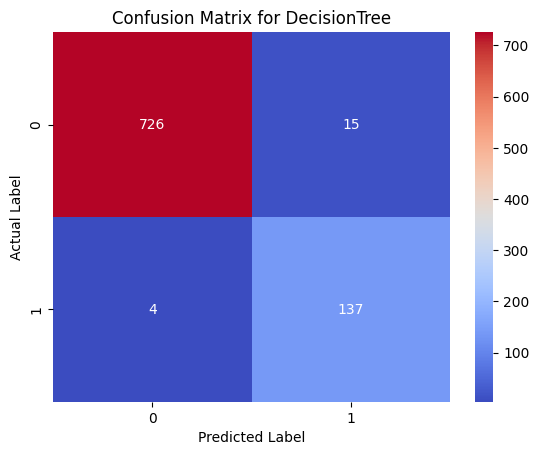

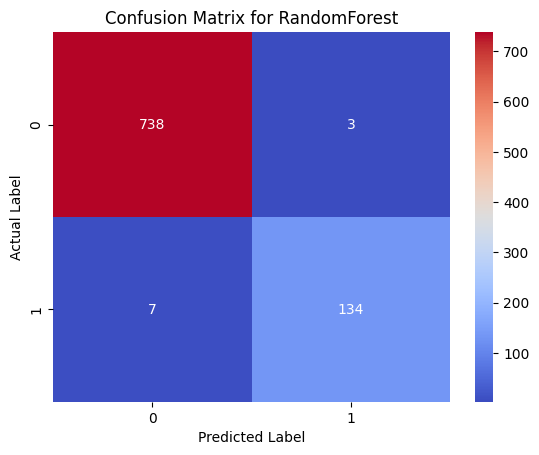

In [211]:
for name, y_pred in predictions.items():
    conf_matrix_rf = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix_rf,fmt='d', annot=True, cmap='coolwarm')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label') # Crucial for clarity
    plt.ylabel('Actual Label')    # Crucial for clarity
    plt.show()